# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.linear_model import RidgeClassifier,LogisticRegression,LassoCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import learning_curve, cross_val_score,train_test_split,StratifiedShuffleSplit,StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,f1_score,average_precision_score,precision_score
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2,SelectFromModel

In [60]:
data=pd.read_csv('orange_small_churn_train_data.csv')
data=data.drop('ID',1)
data.shape
data.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230,labels
count,570.000000,1006.000000,1005.000000,1275.000000,1.165000e+03,35565.000000,35560.000000,0.0,570.000000,1.165000e+03,...,1006.000000,0.0,570.000000,570.00000,1006.000000,16785.000000,266.000000,0.0,0.0,40000.000000
mean,11.003509,0.004970,429.328358,0.148235,2.490555e+05,1319.915394,6.792126,NaN,47.487719,3.813466e+05,...,7.419483,NaN,3.515789,16.05614,165.108310,270.585523,22637.159019,NaN,NaN,-0.851200
std,34.952792,0.157642,4470.405915,1.396054,6.762021e+05,2609.955770,6.287285,NaN,147.137816,9.353348e+05,...,34.642351,NaN,9.412473,54.96505,113.400173,86.723561,30843.320634,NaN,NaN,0.524848
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000e+00,...,0.000000,NaN,0.000000,0.00000,-6.420000,6.000000,0.000000,NaN,NaN,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,518.000000,0.000000,NaN,4.000000,0.000000e+00,...,0.000000,NaN,0.000000,0.00000,19.380000,204.000000,2419.965000,NaN,NaN,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,854.000000,7.000000,NaN,20.000000,0.000000e+00,...,0.000000,NaN,0.000000,4.00000,196.410000,270.000000,12612.240000,NaN,NaN,-1.000000
75%,16.000000,0.000000,0.000000,0.000000,1.172150e+05,1435.000000,7.000000,NaN,46.000000,2.419740e+05,...,8.000000,NaN,6.000000,14.00000,250.980000,330.000000,32209.560000,NaN,NaN,-1.000000
max,536.000000,5.000000,130668.000000,27.000000,6.048550e+06,131761.000000,35.000000,NaN,2300.000000,1.232559e+07,...,1000.000000,NaN,102.000000,910.00000,628.620000,642.000000,230427.000000,NaN,NaN,1.000000


In [61]:
X_data=data.iloc[:,:230]
y_data=data.iloc[:,230:]

In [4]:
X_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


In [16]:
X_dataT=pd.read_csv('orange_small_churn_test_data.csv')
X_dataT.shape

(10000, 231)

In [19]:
X_dataT=X_dataT.drop('ID',1)
X_dataT

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,...,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,NaN,...,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,...,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,140.0,0.0,NaN,NaN,NaN,...,oslk,T3zAKIt,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,6027.0,7.0,NaN,NaN,NaN,...,oslk,2JfQ3DB,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,812.0,14.0,NaN,NaN,NaN,...,zCkv,catzS2D,jySVZNlOJy,NaN,xG3x,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86,NaN
8,NaN,NaN,NaN,NaN,NaN,161.0,0.0,NaN,NaN,NaN,...,oslk,QuuQ5_S,LM8l689qOp,NaN,kG3k,7P5s,RAYp,F2FyR07IdsN7I,mj86,NaN
9,NaN,NaN,NaN,NaN,NaN,175.0,0.0,NaN,NaN,NaN,...,d0EEeJi,MHPNycx,LM8l689qOp,NaN,NaN,me1d,nIGXDli,F2FyR07IdsN7I,NaN,NaN


In [27]:
def preproceccing(X_data,X_dataT,number_features,fill,coding):
    #сливаем вместе чтобы провести единообразный препроцессинг и кодирование категорий
    X=pd.concat([X_data,X_dataT])
    print X.shape
    #Отбросим колонки где данных вообще нет
    zero=list()
    print ((X.shape[0]))
    for var in X.columns:
        if (sum(X[var].isnull()) / float(X.shape[0]))>0.9:zero.append(var)
    print 'Колонки ,которые мы отбросили', len(zero)
    real_columns=X.columns.drop(zero)
    print 'Осталось:',len(real_columns)
    X=X[real_columns]
    #Из 230 колонок выбросли уже 154 где нет данных или они заполнены менее чем на 10%
    #разделим на вещ. и категориальные и заполним вещ.пропуски средними,а пропуски категории "NA"
    num_data=X.iloc[:,:42]
    n_columns=num_data.columns.tolist()
    cat_data=X.iloc[:,42:]
    if fill==0: 
        num_data_mean=num_data.fillna(0)
        print fill
    else:
        num_data_mean=num_data.fillna(num_data.mean())
        print fill
    cat_data=cat_data.fillna('NA')
    #Мы видели что есть кат признаки с кол-вом категорий более 10000.Возможно это фамилии или персональные данные,
    #которые сейчас нам будут только мешать.
    #Ясно что эти признаки надо убрать, будут только шуметь.Оставим только только признаки с числом категорий меньше
    #number_features
    k=0
    new=list()
    for var in cat_data.columns:
        if len(cat_data[var].value_counts())!=1 and len(cat_data[var].value_counts())<number_features : 
            k+=1
            #print 'X_train',var,len(cat_data.iloc[:40000,:][var].value_counts()),'   X_test',var,len(cat_data.iloc[40000:,:][var].value_counts())
            new.append(var)
    #print new
    print 'Признаки которые мы оставили',k
    cat=cat_data[new]
    cat_columns=cat.columns.tolist()
    feature_names=n_columns+cat_columns
    #Кодируем их
    if coding=='OneHot':
        cat_code = cat.apply(LabelEncoder().fit_transform)
        cat_code = OneHotEncoder(sparse=False).fit_transform(cat_code)
        print (coding)
    if coding=='Label':
        cat_code = cat.apply(LabelEncoder().fit_transform)
        print (coding)
    print cat_code.shape
    #Разделяем выборки заново
    print cat_code
    cat_codeL=cat_code[:40000,:]
    cat_codeT=cat_code[40000:,:]
    num_data_meanL=num_data_mean.iloc[:40000,:]
    num_data_meanT=num_data_mean.iloc[40000:,:]
    #Масштабируем признаки
    num_data_meanL=StandardScaler().fit_transform(num_data_meanL)
    num_data_meanT=StandardScaler().fit_transform(num_data_meanT)
    #Собираем признаки вместе
    X_selectL=np.hstack( (num_data_meanL,cat_codeL))
    X_selectT=np.hstack( (num_data_meanT,cat_codeT))
    print X_selectL.shape
    print X_selectT.shape
        
    return  X_selectL,X_selectT,feature_names

In [6]:
X_select = preproceccing(X_data,number_features=100,fill=1,coding='OneHot')

40000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 22
OneHot
(40000L, 326L)
(40000L, 368L)


In [9]:
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
print X.shape,X_holdout.shape
print y.shape,y_holdout.shape

(28000L, 368L) (12000L, 368L)
(28000L,) (12000L,)


In [5]:
cv=StratifiedKFold(n_splits=3)
train_sizes=np.linspace(.1, 1.0, 10)

In [9]:
clf=GradientBoostingClassifier(n_estimators=100,random_state=1)

In [14]:
train_sizes, train_scores, test_scores = learning_curve(
        clf, X, y, cv=cv, train_sizes=train_sizes)

In [15]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

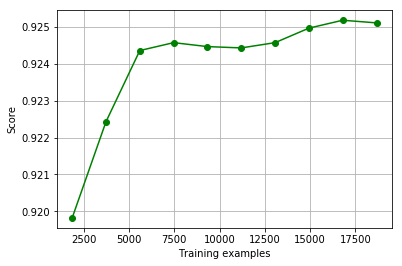

In [16]:
plt.grid()
#plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")

Видно, что для оценки достаточно 5000,т.е. 1/4 выборки.При 3/4 качество незначительно улучшается

2. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [17]:
print 'Соотношение классов',(-sum([-1. for l in data['labels'] if l == -1]))/(sum([1. for l in data['labels'] if l == 1]))

Соотношение классов 12.4408602151


In [18]:
(sum([1. for l in data['labels'] if l == 1]))

2976.0

Попробуем обучить логрегрессию, для которой доступен параметр class_weight.Попробуем автоматически сбалансировать 
классы и выбрать варианты веса минорного класса:2,4,8,12

In [19]:
clf = LogisticRegression(class_weight = 'balanced', random_state = 1)
f1=cross_val_score(clf, X, y, scoring='f1',cv=cv)
avr=cross_val_score(clf,X,y,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf,X,y,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

f1                0.196519829832
average_precision 0.153772985737
roc_auc           0.669220931852


In [20]:
w=[{-1:1,1:2},{-1:1,1:4},{-1:1,1:8},{-1:1,1:10},{-1:1,1:12}]
for n in w:
    clf = LogisticRegression(class_weight = n, random_state = 1)
    f1=cross_val_score(clf, X, y, scoring='f1',cv=cv)
    avr=cross_val_score(clf,X,y,scoring = 'average_precision',cv=cv)
    auc=cross_val_score(clf,X,y,scoring = 'roc_auc',cv=cv)
    print n,f1.mean(),avr.mean(),auc.mean()

{1: 2, -1: 1} 0.0723882755831 0.157583787925 0.672519423853
{1: 4, -1: 1} 0.161929950628 0.156480102289 0.670988113775
{1: 8, -1: 1} 0.212831306861 0.154575427056 0.669176357401
{1: 10, -1: 1} 0.205799798501 0.153867813275 0.668545640981
{1: 12, -1: 1} 0.195894454401 0.153274742561 0.668013035712


Видно что F-мера достигает максимума при весе 8 для минорного класса.Остальные метрики незначительно снизилсь.Предполагаю,что нужно балансировать именно в таком соотношении.Наверное можно подобрать точнее

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Перебираем в параметре size кол-во объектов мажорного класса,которое будет в обучении.Оставляем 1/12, 2/12, 1/4 , 1/2, 10/12

In [31]:
np.random.seed(1)
number=[1, 2, 3, 6, 10]
for n in number:
    indices_to_exl = np.random.randint(np.sum(y==-1),size=(np.sum(y==-1)*n/12))
    X_0 =X[y == -1,:][indices_to_exl,:]
    X_1=X[y==1,:]
    #print X_0.shape
    #print X_1.shape
    X_new=np.vstack( (X_1,X_0 ))
    y_0=y[y ==-1][:len(X_0)]
    y_1=y[y==1]
    np.array(y_0).shape
    np.array(y_1).shape
    y_new=np.hstack((y_1, y_0))
    #print X_new.shape
    #print y_new.shape
    X_exl,y_exl = shuffle(X_new, y_new)
    clf = GradientBoostingClassifier(n_estimators=100,random_state=1)
    f1=cross_val_score(clf, X_exl, y_exl, scoring='f1',cv=cv)
    avr=cross_val_score(clf,X_exl,y_exl,scoring = 'average_precision',cv=cv)
    auc=cross_val_score(clf,X_exl,y_exl,scoring = 'roc_auc',cv=cv)
    print 'Кол-во объектов мажорного класса ,которое в обучении,в %',round(float(n/12.*100),2)
    print 'f1               ',f1.mean()
    print 'average_precision',avr.mean()
    print 'roc_auc          ',auc.mean()

Кол-во объектов мажорного класса ,которое в обучении,в % 8.33
f1                0.667553921458
average_precision 0.712182491418
roc_auc           0.733748036864
Кол-во объектов мажорного класса ,которое в обучении,в % 16.67
f1                0.43977053216
average_precision 0.576068891531
roc_auc           0.741654294119
Кол-во объектов мажорного класса ,которое в обучении,в % 25.0
f1                0.213851809825
average_precision 0.460092856492
roc_auc           0.727618869948
Кол-во объектов мажорного класса ,которое в обучении,в % 50.0
f1                0.0842506783996
average_precision 0.318266726749
roc_auc           0.732296452579
Кол-во объектов мажорного класса ,которое в обучении,в % 83.33
f1                0.0360641821514
average_precision 0.231302484942
roc_auc           0.736382519406


Как видно все метрики ухудшаются при увеличении объектов мажорного класса.Однако примечателен максимум roc-auc,который 
достигнут при соотношении классов приблизительно 1 к 2 (1:-1).Т.е. убрали чуть более 80% мажорного класса из обучения

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Попробуем сравнить варианты заполнения вещественных признаков средними и нулем ,а также два разных варианта 
кодирования 

In [11]:
X_select = preproceccing(X_data,number_features=100,fill=1,coding='Label')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
#обучение
clf = GradientBoostingClassifier(n_estimators=100,random_state=1)
f1=cross_val_score(clf, X, y, scoring='f1',cv=cv)
avr=cross_val_score(clf, X, y,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf, X, y,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

40000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 22
Label
(40000, 22)
(40000L, 64L)
f1                0.0278221098437
average_precision 0.194577354737
roc_auc           0.731741399067


In [12]:
X_select = preproceccing(X_data,number_features=100,fill=0,coding='Label')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
#обучение
clf = GradientBoostingClassifier(n_estimators=100,random_state=1)
f1=cross_val_score(clf, X, y, scoring='f1',cv=cv)
avr=cross_val_score(clf,X, y,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf,X, y,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

40000
Колонки ,которые мы отбросили 154
Осталось: 76
0
Признаки которые мы оставили 22
Label
(40000, 22)
(40000L, 64L)
f1                0.0287812844591
average_precision 0.194276708129
roc_auc           0.727823186685


Видно что при заполнении 0 метрика ухудшилась.Качество хуже ,чем при заполнении средними.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [13]:
X_select = preproceccing(X_data,number_features=100,fill=1,coding='Label')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
#обучение
clf = GradientBoostingClassifier(n_estimators=100,random_state=1)
f1=cross_val_score(clf, X, y, scoring='f1',cv=cv)
avr=cross_val_score(clf,X,y,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf,X,y,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

40000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 22
Label
(40000, 22)
(40000L, 64L)
f1                0.0278221098437
average_precision 0.194577354737
roc_auc           0.731741399067


In [14]:
X_select = preproceccing(X_data,number_features=100,fill=1,coding='OneHot')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)

clf = GradientBoostingClassifier(n_estimators=100,random_state=1)
f1=cross_val_score(clf, X, y, scoring='f1',cv=cv)
avr=cross_val_score(clf,X,y,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf,X,y,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

40000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 22
OneHot
(40000L, 326L)
(40000L, 368L)
f1                0.0204925867164
average_precision 0.194815339359
roc_auc           0.732113575152


#Разные методы кодирования не показывают каких-либо существенных отличий.Будем использовать Label,т.к. он значительно сокращает время обучения модели.Попробуем также ради проверки увеличить фильтр для кол-ва категорий до 1000

In [15]:
X_select = preproceccing(X_data,number_features=1000,fill=1,coding='Label')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
#обучение
clf = GradientBoostingClassifier(n_estimators=100,random_state=1)
f1=cross_val_score(clf, X, y, scoring='f1',cv=cv)
avr=cross_val_score(clf,X,y,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf,X,y,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

40000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 25
Label
(40000, 25)
(40000L, 67L)
f1                0.0241508628265
average_precision 0.191533025029
roc_auc           0.7313322052


Толку никакого))) Значит явно надо занятся целевым отбором признаков

In [17]:
X_select = preproceccing(X_data,number_features=100,fill=1,coding='Label')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
#балансировка
np.random.seed(1)
number=[8, 9, 10]
for n in number:
    indices_to_add = np.random.randint(np.sum(y==1),size=(np.sum(y==-1)-np.sum(y==1))*n/12)
    X_a =X[y == 1,:][indices_to_add,:]
    X_add=np.vstack( (X,X_a) )
    ones= np.ones(len(X_a))
    y_add=np.hstack((y, ones))
    y_add.shape
    #обучение
    clf = GradientBoostingClassifier(n_estimators=100,random_state=1)
    f1=cross_val_score(clf, X_add, y_add, scoring='f1',cv=cv)
    avr=cross_val_score(clf,X_add,y_add,scoring = 'average_precision',cv=cv)
    auc=cross_val_score(clf,X_add,y_add,scoring = 'roc_auc',cv=cv)
    print 'f1               ',f1.mean()
    print 'average_precision',avr.mean()
    print 'roc_auc          ',auc.mean()

40000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 22
Label
(40000, 22)
(40000L, 64L)
f1                0.615726195665
average_precision 0.706565306155
roc_auc           0.788494589937
f1                0.645679715228
average_precision 0.72439094296
roc_auc           0.788041734718
f1                0.681287301331
average_precision 0.742487429002
roc_auc           0.789833625677


5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

Попробуем отбор признаков с помощью l1-регуляризации LogisticRegression ,а также отбора из randomforest для дальнейшего использования в бустинге.Кол-во категорий увеличим до 1000,посмотрим как будут отбираться признаки,сбалансируем выборку ,досэмплировав объекты минорного класса

In [11]:
X_select,feature_names = preproceccing(X_data,number_features=1000,fill=1,coding='Label')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
#балансировка
np.random.seed(1)
indices_to_add = np.random.randint(np.sum(y==1),size=(np.sum(y==-1)-np.sum(y==1)))
X_a =X[y == 1,:][indices_to_add,:]
X_add=np.vstack( (X,X_a) )
ones= np.ones((np.sum(y==-1)-np.sum(y==1)))
y_add=np.hstack((y, ones))
y_add.shape
#обучение
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1',class_weight ='balanced', random_state = 1))),
  ('classification', GradientBoostingClassifier(n_estimators=100,random_state=1))
])

f1=cross_val_score(clf, X_add, y_add, scoring='f1',cv=cv)
avr=cross_val_score(clf,X_add,y_add,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf,X_add,y_add,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

40000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 25
Label
(40000, 25)
(40000L, 67L)
f1                0.720759506436
average_precision 0.771418425742
roc_auc           0.790215765455


In [12]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=1))),
  ('classification', GradientBoostingClassifier(n_estimators=100,random_state=1))
])

f1=cross_val_score(clf, X_add, y_add, scoring='f1',cv=cv)
avr=cross_val_score(clf,X_add,y_add,scoring = 'average_precision',cv=cv)
auc=cross_val_score(clf,X_add,y_add,scoring = 'roc_auc',cv=cv)
print 'f1               ',f1.mean()
print 'average_precision',avr.mean()
print 'roc_auc          ',auc.mean()

f1                0.714295305341
average_precision 0.754379437079
roc_auc           0.777552076488


При использовании лог. регрессии получили результат лучше чем при random forest.Оставим ее.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [139]:
#балансировка
np.random.seed(1)
indices_to_add = np.random.randint(np.sum(y==1),size=(np.sum(y==-1)-np.sum(y==1)))
X_a =X[y == 1,:][indices_to_add,:]
X_add=np.vstack( (X,X_a) )
ones= np.ones((np.sum(y==-1)-np.sum(y==1)))
y_add=np.hstack((y, ones))
y_add.shape

(51834L,)

In [6]:
cv=StratifiedKFold(n_splits=3)

In [141]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1',class_weight ='balanced', random_state = 1))),
  ('classification', GradientBoostingClassifier(random_state=1))
])

In [142]:
clf.get_params()

{'classification': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_split=1e-07, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=100, presort='auto', random_state=1,
               subsample=1.0, verbose=0, warm_start=False),
 'classification__criterion': 'friedman_mse',
 'classification__init': None,
 'classification__learning_rate': 0.1,
 'classification__loss': 'deviance',
 'classification__max_depth': 3,
 'classification__max_features': None,
 'classification__max_leaf_nodes': None,
 'classification__min_impurity_split': 1e-07,
 'classification__min_samples_leaf': 1,
 'classification__min_samples_split': 2,
 'classification__min_weight_fraction_leaf': 0.0,
 'classification__n_estimators': 100,
 'classification__presort': 'auto',
 'classification__random_stat

parameters_grid = {
    'classification__n_estimators': [50,100,150,200],
    'classification__min_samples_leaf' : [3,5,7],
    'classification__max_depth': [3,5,7],
    'classification__learning_rate': [0.1,0.05,0.01],
}

In [143]:
parameters_grid = {
    'classification__n_estimators': [100,150,200],
    'classification__min_samples_leaf' : [3,5,7],
    'classification__max_depth': [3,5,7],
    }

In [144]:
grid_cv = GridSearchCV(clf, parameters_grid, scoring = 'roc_auc', cv = cv)

In [145]:
%%time
grid_cv.fit(X_add, y_add)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.989908746551
{'classification__min_samples_leaf': 5, 'classification__n_estimators': 200, 'classification__max_depth': 7}
Wall time: 1h 7min 54s


Судя по результату мы явно переобучили классификатор)).Проверим на тестовой выборке .

In [146]:
gb_predictions=grid_cv.predict_proba(X_holdout)
gb_predictions1=grid_cv.predict(X_holdout)

In [147]:
auc=roc_auc_score(y_holdout,gb_predictions[:,1]  ) 
print(classification_report(y_holdout,gb_predictions1 ) )
f1=f1_score(y_holdout,gb_predictions1)
avr=average_precision_score(y_holdout,gb_predictions1)
print 'f1               ',f1
print 'average_precision',avr
print 'roc_auc          ',auc

             precision    recall  f1-score   support

         -1       0.94      0.90      0.92     11107
          1       0.19      0.28      0.23       893

avg / total       0.88      0.86      0.87     12000

f1                0.225441376188
average_precision 0.260855889724
roc_auc           0.692282572323


Видно что результат неудовлетворительный.Попробуем подобрать learning rate,чтобы компенсировать переобучение

In [13]:
lr=[0.01,0.005,0.001,0.0005]
for l in lr:
    clf = Pipeline([
      ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1',class_weight ='balanced', random_state = 1))),
      ('classification', GradientBoostingClassifier(n_estimators=200,max_depth=7, min_samples_leaf=5,learning_rate=l,random_state=1))
        ])
    auc=cross_val_score(clf,X_add,y_add,scoring = 'roc_auc',cv=cv)
    print 'roc_auc          ',auc.mean()
    clf.fit(X_add, y_add)
    gb_predictions=clf.predict_proba(X_holdout)
    gb_predictions1=clf.predict(X_holdout)
    auc=roc_auc_score(y_holdout,gb_predictions[:,1]  ) 
    print(classification_report(y_holdout,gb_predictions1 ) )
    f1=f1_score(y_holdout,gb_predictions1)
    avr=average_precision_score(y_holdout,gb_predictions1)
    print 'f1               ',f1
    print 'average_precision',avr
    print 'roc_auc          ',auc

roc_auc           0.857806273594
             precision    recall  f1-score   support

         -1       0.96      0.73      0.83     11107
          1       0.15      0.59      0.24       893

avg / total       0.90      0.72      0.79     12000

f1                0.239016617346
average_precision 0.384286300859
roc_auc           0.724615924241
roc_auc           0.824827876294
             precision    recall  f1-score   support

         -1       0.96      0.71      0.81     11107
          1       0.14      0.62      0.23       893

avg / total       0.90      0.70      0.77     12000

f1                0.2331002331
average_precision 0.39411902811
roc_auc           0.718045458455
roc_auc           0.782262490983
             precision    recall  f1-score   support

         -1       0.96      0.67      0.79     11107
          1       0.13      0.63      0.22       893

avg / total       0.90      0.67      0.75     12000

f1                0.218281036835
average_precision 0.39349373

Толку никакого.Видимо увеличение параметров max_depth, min_samples_leaf нам не приносит результата.Попробуем другой подход.Подберем кол-во n_estimators и learning_rate,так чтобы модель на тесте давала метрику не сильно хуже.

In [31]:
auccv_data=np.zeros((5, 5))
auctest_data=np.zeros((5, 5))
learn_rate=np.array([0.1,0.05,0.01,0.005,0.001])
est=np.array([200,400,600,800,1000])
for i in range(len(est)):
    for j in range (len(learn_rate)):
        clf = Pipeline([
          ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1',class_weight ='balanced', random_state = 1))),
          ('classification', GradientBoostingClassifier(n_estimators=est[i],learning_rate=learn_rate[j],random_state=1))
            ])
        auc_cv=cross_val_score(clf,X_add,y_add,scoring = 'roc_auc',cv=cv).mean()
        print 'Number estimator',est[i],'learning rate',learn_rate[j]
        print 'roc_auc_cv          ',auc_cv
        auccv_data[i][j]=auc_cv
        clf.fit(X_add, y_add)
        gb_predictions=clf.predict_proba(X_holdout)
        auc_test=roc_auc_score(y_holdout,gb_predictions[:,1]  ) 
        print 'roc_auc_test          ',auc_test
        auctest_data[i][j]=auc_test

Number estimator 200 learning rate 0.1
roc_auc_cv           0.827515031993
roc_auc_test           0.733051733061
Number estimator 200 learning rate 0.05
roc_auc_cv           0.790839865032
roc_auc_test           0.738974321955
Number estimator 200 learning rate 0.01
roc_auc_cv           0.742065060972
roc_auc_test           0.737483680832
Number estimator 200 learning rate 0.005
roc_auc_cv           0.726897041475
roc_auc_test           0.726017288211
Number estimator 200 learning rate 0.001
roc_auc_cv           0.706081636311
roc_auc_test           0.705935776304
Number estimator 400 learning rate 0.1
roc_auc_cv           0.874917637896
roc_auc_test           0.723397097015
Number estimator 400 learning rate 0.05
roc_auc_cv           0.826585510675
roc_auc_test           0.732959683325
Number estimator 400 learning rate 0.01
roc_auc_cv           0.759282364629
roc_auc_test           0.742637961936
Number estimator 400 learning rate 0.005
roc_auc_cv           0.742157154673
roc_auc_tes

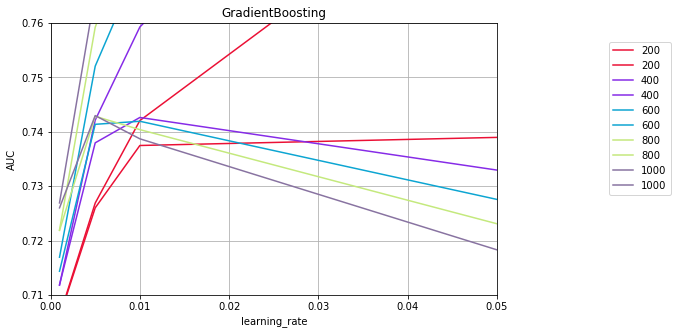

In [40]:
plt.figure(figsize=(8, 5))
for i in range(len(est)):
    plt.plot(learn_rate, auccv_data[i],learn_rate,auctest_data[i], label=est[i], color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.grid()
plt.xlim(0.0,0.05)
plt.ylim(0.71,0.76)
plt.xlabel("learning_rate")
plt.ylabel("AUC")
plt.title("GradientBoosting")

Такой подход дал более приемлимый результат.Хотя наилучшие результаты по метрике roc_auc_cv=0.765605353477 roc_auc_test 0.742983728168 достигнуты при n_estimators=1000 и learning_rate=0.005 предполагаю,что 0,74-0,75 пределы алгоритма при данных вводных и смысла увеличивать дальше кол-во n_estimators нет.
Выбираю n_estimators=400 и learning_rate=0.01.Метрики не сильно хуже 
roc_auc_cv           0.759282364629
roc_auc_test         0.742637961936

In [46]:
X_selectL, X_selectT,feature_names = preproceccing(X_data,X_dataT,number_features=1000,fill=1,coding='OneHot')
X, X_holdout, y, y_holdout = train_test_split(X_selectL, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)
#балансировка
np.random.seed(1)
indices_to_add = np.random.randint(np.sum(y==1),size=(np.sum(y==-1)-np.sum(y==1)))
print y.shape
print indices_to_add.shape
print X_selectL.shape
print indices_to_add.min()
X_a =X[y == 1,:][indices_to_add,:]
X_add=np.vstack( (X,X_a) )
print X_add.shape
ones= np.ones((np.sum(y==-1)-np.sum(y==1)))
y_add=np.hstack((y, ones))
y_add.shape

(50000, 230)
50000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 25
OneHot
(50000L, 1018L)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]
(40000L, 1060L)
(10000L, 1060L)
(28000L,)
(23834L,)
(40000L, 1060L)
0
(51834L, 1060L)


(51834L,)

In [47]:
 clf = Pipeline([
      ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1',class_weight ='balanced', random_state = 1))),
      ('classification', GradientBoostingClassifier(n_estimators=400,learning_rate=0.01,random_state=1))
        ])

In [48]:
auc=cross_val_score(clf,X_add,y_add,scoring = 'roc_auc',cv=cv)
print 'roc_auc          ',auc.mean()

roc_auc           0.759320862249


In [49]:
print X_add.shape

(51834L, 1060L)


In [53]:
#clf.fit(X_add, y_add)
gb_predictions=clf.predict_proba(X_holdout)
gb_predictions1=clf.predict(X_holdout)

In [58]:
auc=roc_auc_score(y_holdout,gb_predictions[:,1]  ) 
print(classification_report(y_holdout,gb_predictions1 ) )
f1=f1_score(y_holdout,gb_predictions1)
avr=average_precision_score(y_holdout,gb_predictions1)
print 'f1               ',f1
print 'average_precision',avr
print 'roc_auc          ',auc

             precision    recall  f1-score   support

         -1       0.96      0.66      0.79     11107
          1       0.14      0.70      0.24       893

avg / total       0.90      0.67      0.75     12000

f1                0.237740889143
average_precision 0.431716322445
roc_auc           0.74455558075


In [52]:
rez=pd.DataFrame(data=gb_predictions[:,1], columns=['result'])
rez.to_csv('res.csv',index=True, index_label='Id')

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [7]:
X_select,feature_names = preproceccing(X_data,number_features=1000,fill=1,coding='Label')
X, X_holdout, y, y_holdout = train_test_split(X_select, np.array(y_data).reshape(40000,), 
                                              test_size=0.3, random_state=0, stratify=y_data)


40000
Колонки ,которые мы отбросили 154
Осталось: 76
1
Признаки которые мы оставили 25
Label
(40000, 25)
(40000L, 67L)


Посмотрим еще раз на отбор признаков с помощью l1-регуляризации LogisticRegression.Предполагаем что наибольший вклад в модель внесли признаки с наибольшими весами. Упорядочим коэффициэнты при признаках и выведем их абсолютные значения.

In [135]:
clf = LogisticRegression(penalty='l1',class_weight = 'balanced', random_state = 1)
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [65]:
importances = np.absolute(clf.coef_.reshape(67,))
indices = np.argsort(importances)[::-1]
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

AttributeError: 'Pipeline' object has no attribute 'coef_'

Для наглядности отобразим первые 40 на графике.Данные признаки внесли основной вклад в модель.

NameError: name 'importances' is not defined

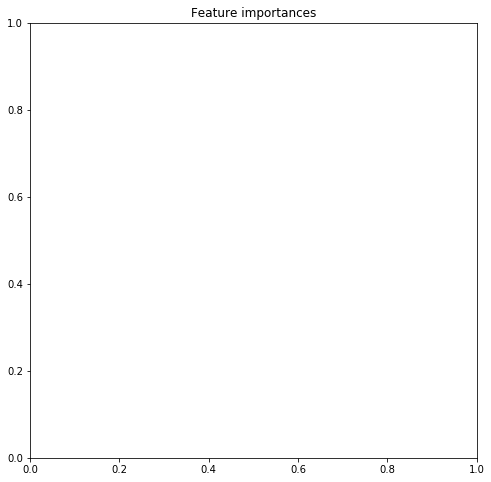

In [64]:
d_first = 40
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

Считаем что большая доля уверенности - это более 60%

In [28]:
predict = pd.DataFrame({'-1':gb_predictions[:,0],'1':gb_predictions[:,1]})
predict['test_label'] = y_holdout
predict['mistake']=np.zeros(len(predict))
predict
for i in range (len(predict)):
    if predict.iloc[i,2]==1 and predict.iloc[i,0]>0.6:predict.iloc[i,3]=1
    if predict.iloc[i,2]==-1 and predict.iloc[i,1]>0.6:predict.iloc[i,3]=1   
m=predict[predict.mistake==1]

,-1,1,test_label,mistake
1,0.337326,0.662674,-1,1.0
16,0.662062,0.337938,1,1.0
23,0.333749,0.666251,-1,1.0
29,0.351904,0.648096,-1,1.0
33,0.294216,0.705784,-1,1.0
37,0.620487,0.379513,1,1.0
43,0.377559,0.622441,-1,1.0
74,0.288612,0.711388,-1,1.0
91,0.395696,0.604304,-1,1.0
105,0.366926,0.633074,-1,1.0


In [33]:
pr=X_holdout[m.index]

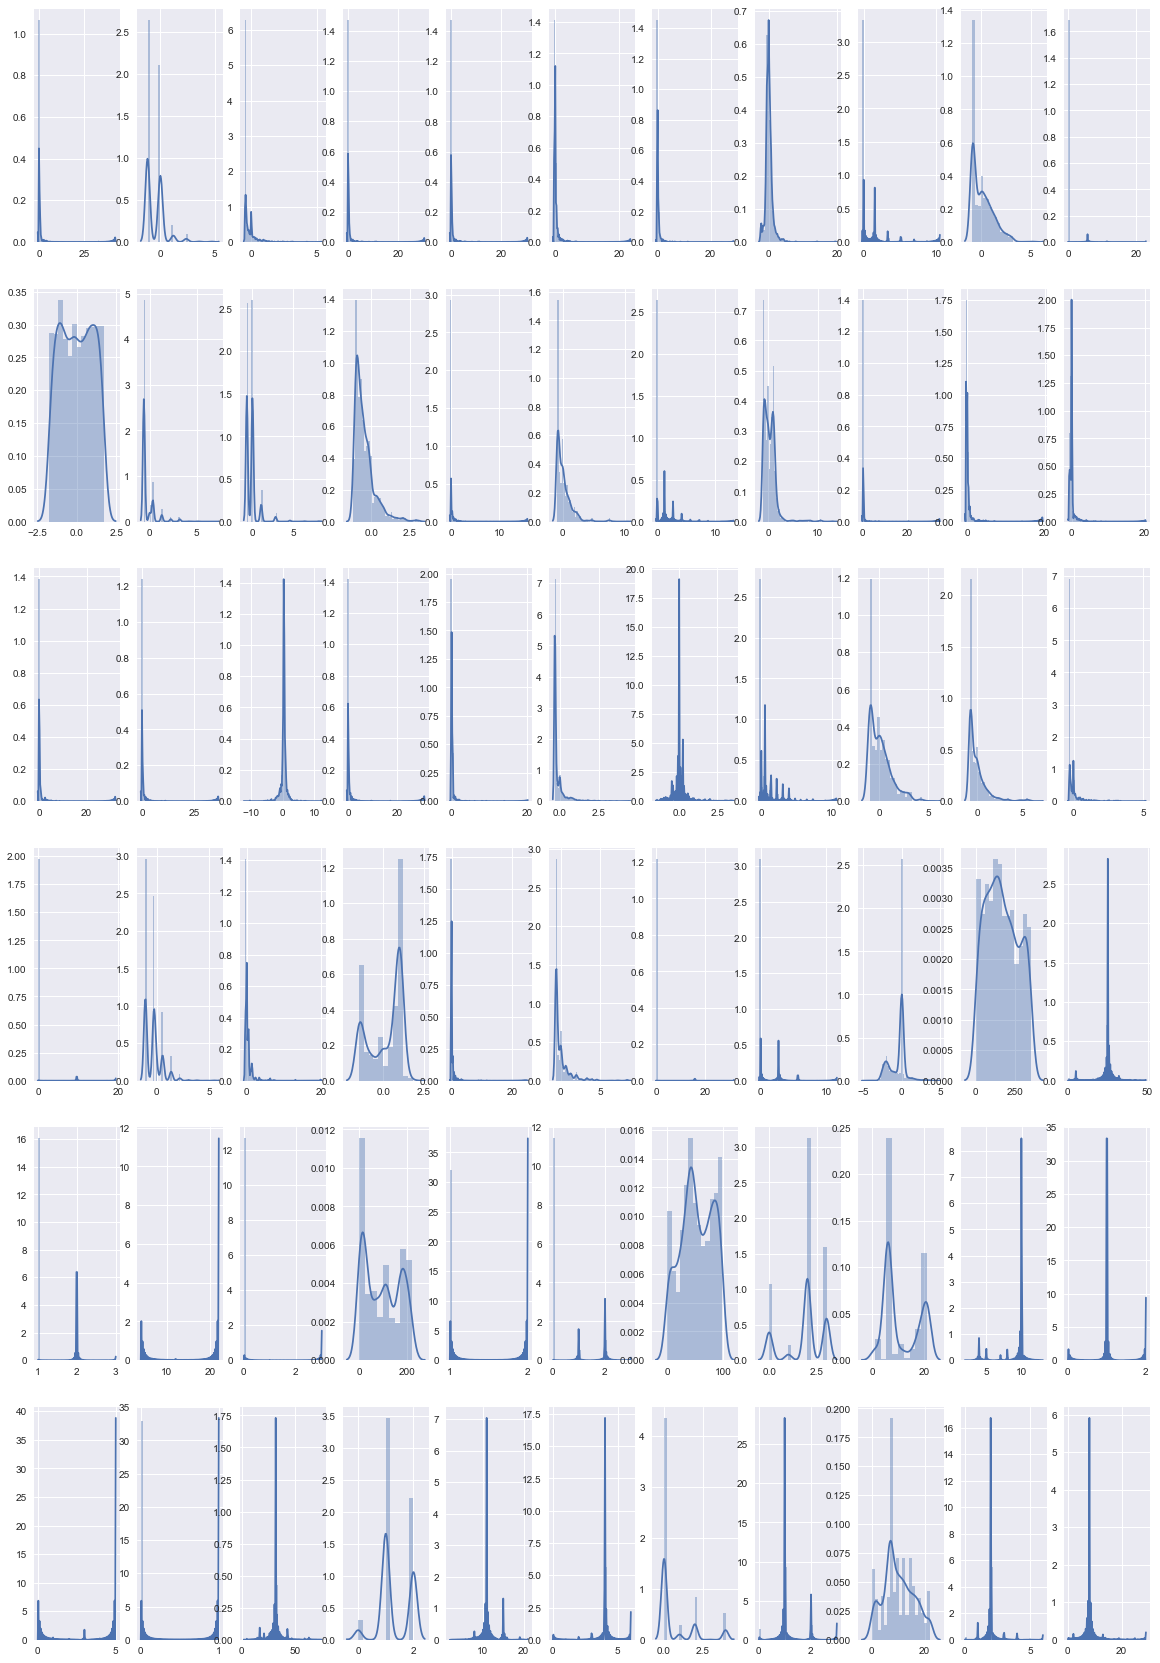

In [34]:
import seaborn

fig, ax = plt.subplots(6, 11, figsize = (20, 30))
for i in range(66):
    seaborn.distplot(pr[:,i], ax = ax[i//11, i%11])
    
plt.show()

У многих признаков хвосты и выбросы.Надо понимать что это значит ...

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Для построения финального решения сделано:
1.Предпроцессинг
-из датасета удалены все признаки ,которые не содержат данных или содержат менее 10% а также категориальные признаки ,где кол-во категорий превышает 1000
-все пропуски в вещественных признаках заполнены средними,а пропуски в категориальных заполнены категорией NA
-вещественные признаки отмасштабированы, категориальные кодированы методом LabelEncoder
2.Выборка разделена на обучающую и тестовую.Проведен подбор моделей по кроссвалидации , метод StratifiedKFold с кол-вом фолдов три.Выбран бустинг,дающий максимальную метрику по ROC-AUC на кросс-валидации.Для балансировки классов проведено досэмплирование выборки объектами минорного класса,что улучшило метрики(это видно по F1-мере).
3.Проведен дополнительные отбор признаков с помощью pipeline,метода SelectFromModel и лог.регрессии с параметром регуляризации l1 и их графический анализ.
4.Проведена процедура подбора параметров модели с помощьюGridSearchCV.
5.Проведен дополнительно подбор параметров с помощью сравнения результатов на кросс-валидации и тесте.

In [35]:
 clf = Pipeline([
      ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1',class_weight ='balanced', random_state = 1))),
      ('classification', GradientBoostingClassifier(n_estimators=400,learning_rate=0.01,random_state=1))
        ])
auc=cross_val_score(clf,X_add,y_add,scoring = 'roc_auc',cv=cv)
print 'roc_auc          ',auc.mean()

roc_auc           0.759282364629


In [36]:
clf.fit(X_add, y_add)
gb_predictions=clf.predict_proba(X_holdout)
auc=roc_auc_score(y_holdout,gb_predictions[:,1]  ) 
print 'roc_auc_test          ',auc

roc_auc_test           0.742637961936


10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Возможно стоит еще поэкспериментировать на параметрах , подборе и препроцессинге признаков.Однако чтобы кардинально улучшить модель  необходимо знать физический смысл признаков.